# Proyecto 1 - Análitica de textos - Etapa 1 

## Integrantes
- Carlos Vargas - 202220064
- Silvana Echeverry - 202310470
- David Mora - 202226269

El objetivo del proyecto es construir un modelo de aprendizaje supervisado de clasificación de texto. Se espera que dado un nuevo texto de opinión, el modelo debe predecir automáticamente a cuál ODS pertenece. No es una variable binaria sino multiclase (1,3,4)

# 2. Entendimiento y preparación de los Datos

## Entendimiento - Carga de Datos

In [4]:
# Imports 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats as st

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re, unicodedata

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [6]:
data = pd.read_excel('Datos_proyecto.xlsx')
#print(data.head())
#data.info()

Revisar como estan distribuidos nuestros datos: 

1. Contar cuantos labels hay, lo cual nos confirma que tenemos, para confirmar si tenemos desbalanceo o balanceo en nuestras clases 
- 4 1025 (Calidad de vida)
-  3 894 (salud)
- 1 505 (educación)
2. Ver la proporción que representa cada clase con respecto al total de los datos. 
- 4 42%
- 3 36% 
- 1 20% menor representación
el label 4 y 3 estan mas parejas 

3. Mostrar la grafica 
- con la grafica podemos ver que nuestras label tienen un leve desbalance pero consideramos que podemos seguir trabajando 


labels
4    1025
3     894
1     505
Name: count, dtype: int64
labels
4    0.422855
3    0.368812
1    0.208333
Name: proportion, dtype: float64


/var/folders/0g/xm2gc5sx67sds29_nv2g25n00000gn/T/ipykernel_39493/405444549.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=data, palette="Set2")


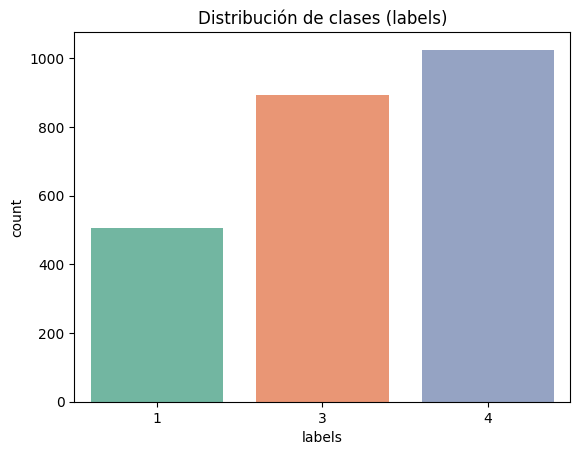

In [7]:
# Conteo de ejemplos por clase
print(data['labels'].value_counts())

# Proporción de ejemplos por clase
print(data['labels'].value_counts(normalize=True))

sns.countplot(x='labels', data=data, palette="Set2")
plt.title("Distribución de clases (labels)")
plt.show()

Con esto verificamos las longitudes de los textos y las palabras antes de limpiarlas. 

In [8]:
data_copy = data.copy()
data_copy['conteo'] = [len(x) for x in data_copy['textos']]
data_copy['max'] = [[max([len(x) for x in i.split(' ')])][0] for i in data_copy['textos']]
data_copy['min'] = [[min([len(x) for x in i.split(' ')])][0] for i in data_copy['textos']]
data_copy['mean'] = [np.mean([len(x) for x in i.split(' ')]) for i in data_copy['textos']]

data_copy


,textos,labels,conteo,max,min,mean
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1,6.354167
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1,6.180556
2,"Además, la formación de especialistas en medic...",3,659,15,1,6.096774
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1,5.366972
4,Este grupo se centró en las personas que padec...,3,608,14,0,5.410526
...,...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,741,16,1,5.566372
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,541,15,1,5.376471
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,352,12,1,4.515625
2422,"Sin embargo, estas fallas del mercado implican...",3,754,15,1,4.852713


## Procesamiento de los Datos
#### Limpieza de los datos

En la parte de limpieza de los datos vamos a dejar todo en minusculas, eliminar caracteres especiales, puntuación, nonASCII characters y stopwords  

In [9]:
def limpieza(texto: str) -> str:
    texto = str(texto).lower()                    # minúsculas
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto)
                    if unicodedata.category(c) != 'Mn')   # quitar non-ASCII/tildes
    texto = re.sub(r'[^a-z0-9\s]', ' ', texto)    # eliminar puntuación y caracteres especiales
    texto = re.sub(r'\s+', ' ', texto).strip()    # colapsar espacios
    return texto

#### Tokenización 
Vamos a dividir en frases u oraciones en palabras Con el fin de desglozar las palabras correctamente para el posterior análisis. Como en español no hay contractions no aplicamos esa función. Sin embargo, tenemos en cuenta también las palabras compuestas como niños(as) estas las separamos en tokens diferentes, ademas podemos eliminar comillas, parentesis y guiones. 

In [10]:
def tokenizacion(texto: str):
    tokens = re.findall(r"[a-zA-ZáéíóúÁÉÍÓÚñÑüÜ0-9]+", texto)
    return tokens

#### Normalizacion 
Aqui eliminamos las stopwords. 
- Se utilizo chat gpt para que generara la lista con las spanish stopwords que queremos eliminar, ya que generalmente las librerias estan en ingles y no reconocen las stopwords en español 

In [11]:
spanish_stopwords = [
    'a', 'acá', 'ahí', 'ajena', 'ajenas', 'ajeno', 'ajenos', 'al', 'algo', 'algún', 
    'alguna', 'algunas', 'alguno', 'algunos', 'allá', 'allí', 'ambos', 'ante', 
    'antes', 'aquel', 'aquella', 'aquellas', 'aquello', 'aquellos', 'aquí', 
    'arriba', 'así', 'atrás', 'aun', 'aunque', 'bajo', 'bastante', 'bien', 'cabe', 
    'cada', 'casi', 'cierta', 'ciertas', 'cierto', 'ciertos', 'como', 'con', 
    'conmigo', 'contigo', 'contra', 'cual', 'cuales', 'cualquier', 'cualquiera', 
    'cualquieras', 'cuan', 'cuando', 'cuanta', 'cuantas', 'cuanto', 'cuantos', 
    'de', 'dejar', 'del', 'demás', 'demasiada', 'demasiadas', 'demasiado', 
    'demasiados', 'dentro', 'desde', 'donde', 'dos', 'el', 'él', 'ella', 'ellas', 
    'ello', 'ellos', 'empleáis', 'emplean', 'emplear', 'empleas', 'empleo', 'en', 
    'encima', 'entonces', 'entre', 'era', 'eramos', 'eran', 'eras', 'eres', 'es', 
    'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estado', 'estáis', 
    'estamos', 'estan', 'estar', 'estas', 'este', 'esto', 'estos', 'etc', 'ha', 
    'hace', 'haces', 'hacéis', 'hacemos', 'hacen', 'hacer', 'hacia', 'hago', 
    'hasta', 'incluso', 'intenta', 'intentáis', 'intentamos', 'intentan', 
    'intentar', 'intentas', 'intento', 'ir', 'jamás', 'junto', 'juntos', 'la', 
    'lo', 'los', 'las', 'largo', 'más', 'me', 'menos', 'mi', 'mía', 'mías', 'mío', 
    'míos', 'mis', 'misma', 'mismas', 'mismo', 'mismos', 'modo', 'mucha', 'muchas', 
    'muchísima', 'muchísimas', 'muchísimo', 'muchísimos', 'mucho', 'muchos', 'muy', 
    'nada', 'ni', 'ninguna', 'ningunas', 'ninguno', 'ningunos', 'no', 'nos', 
    'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'nunca', 
    'os', 'otra', 'otras', 'otro', 'otros', 'para', 'parecer', 'pero', 'poca', 
    'pocas', 'poco', 'pocos', 'podeis', 'podemos', 'poder', 'podría', 'podríais', 
    'podríamos', 'podrían', 'por', 'porque', 'primero', 'puede', 'pueden', 'puedo', 
    'pues', 'que', 'querer', 'quien', 'quienes', 'quienesquiera', 'quienquiera', 
    'quizá', 'quizás', 'sabe', 'sabes', 'saben', 'sabéis', 'sabemos', 'saber', 
    'se', 'según', 'ser', 'si', 'sí', 'siendo', 'sin', 'sino', 'so', 'sobre', 
    'sois', 'solamente', 'solo', 'somos', 'soy', 'su', 'sus', 'suya', 'suyas', 
    'suyo', 'suyos', 'tal', 'tales', 'también', 'tampoco', 'tan', 'tanta', 
    'tantas', 'tanto', 'tantos', 'te', 'teneis', 'tenemos', 'tener', 'tengo', 
    'ti', 'tiempo', 'tiene', 'tienen', 'toda', 'todas', 'todo', 'todos', 'tras', 
    'tu', 'tus', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'un', 'una', 'unas', 'uno', 
    'unos', 'usa', 'usáis', 'usamos', 'usan', 'usar', 'usas', 'uso', 'usted', 
    'ustedes', 'va', 'vais', 'valor', 'vamos', 'van', 'varias', 'varios', 'vaya', 
    'verdad', 'verdadera', 'vosotras', 'vosotros', 'voy', 'vuestra', 'vuestras', 
    'vuestro', 'vuestros', 'y', 'ya'
]
def normalizacion(tokens):
    return [t for t in tokens if t not in spanish_stopwords]

Juntar todo lo que hicimos, en una copia de nuestros datos 

In [12]:
data_copy = data.copy()

# Aplicar las funciones de preprocesamiento
data_copy['textos_clean'] = data_copy['textos'].apply(limpieza)
data_copy['tokens'] = data_copy['textos_clean'].apply(tokenizacion)
data_copy['tokens_norm'] = data_copy['tokens'].apply(normalizacion)


# print(data_copy[['tokens_norm','labels']].head(3))
data_copy

,textos,labels,textos_clean,tokens,tokens_norm
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,aprendizaje y educacion se consideran sinonimo...,"[aprendizaje, y, educacion, se, consideran, si...","[aprendizaje, educacion, consideran, sinonimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los ninos mas pequenos bebes y ninos pequ...,"[para, los, ninos, mas, pequenos, bebes, y, ni...","[ninos, mas, pequenos, bebes, ninos, pequenos,..."
2,"Además, la formación de especialistas en medic...",3,ademas la formacion de especialistas en medici...,"[ademas, la, formacion, de, especialistas, en,...","[ademas, formacion, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los paises de la ocde se tiende a pasar de ...,"[en, los, paises, de, la, ocde, se, tiende, a,...","[paises, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,este grupo se centro en las personas que padec...,"[este, grupo, se, centro, en, las, personas, q...","[grupo, centro, personas, padecen, trastornos,..."
...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,la tutoria de carrera esta disenada para apoya...,"[la, tutoria, de, carrera, esta, disenada, par...","[tutoria, carrera, disenada, apoyar, estudiant..."
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,fuente ministerio de educacion las tasas inter...,"[fuente, ministerio, de, educacion, las, tasas...","[fuente, ministerio, educacion, tasas, interna..."
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,y desde 2010 el pnud ha sido pionero en la pue...,"[y, desde, 2010, el, pnud, ha, sido, pionero, ...","[2010, pnud, sido, pionero, puesta, marcha, pr..."
2422,"Sin embargo, estas fallas del mercado implican...",3,sin embargo estas fallas del mercado implican ...,"[sin, embargo, estas, fallas, del, mercado, im...","[embargo, fallas, mercado, implican, competenc..."


In [13]:
# exportar a excel para saber como nos esta quedando
# data_copy[['textos','tokens_norm']].to_excel("tokens_norm.xlsx", index=False)

#### Selección de campos y vectorizacion 
Esto nos permite traducir nuestras palabras ya tokenizadas en numeros ya que los modelos que vamos a usar no nos funcionan con palabras sino con numeros. 
Basicamente lo que vamos a hacer es: 
1. Selección de campos: separar que columna es la variable predictora y cual es la variable objetivo (lo organiza para que sklearn lo entienda)
2. Vectorización: convierte cada texto en un vector indicando cuántas veces aparece cada palabra.
3. TfidfVectorizer: pondera cada palabra por su importancia en el documento y en el corpus. penaliza palabras que no nos esten aportantando tanto y favore a las que si. 
4. Construcción de la matriz: construimos una matriz de documentos vs vocabulario, 
- Cada fila = un documento (texto del dataset).
- Cada columna = una palabra del vocabulario.
- El valor = la frecuencia o el peso TF-IDF de esa palabra en ese documento.

Entonces, esto va a traducir el texto en números para que los modelos puedan trabajar. Además, esta matriz sirve para identificar palabras relevantes en cada clase, lo cual necesitamos para justificar cómo los textos se relacionan con los ODS.

Hacemos la selección de campos

In [14]:
data_ready = data_copy.copy()

data_ready['words'] = data_ready['tokens_norm'].apply(lambda xs: ' '.join(map(str, xs)))

X_data = data_ready['words']
y_data = data_ready['labels'].astype(int)

#print(X_data.head(2))
#print(y_data.value_counts().sort_index())

Vectorización

Presencia binaria (Bag-of-Words binario): No importa cuántas veces aparezca una palabra en el texto. Solo se indica si la palabra está presente (1) o ausente (0).

In [15]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data)

# print("BoW binario:", X_dummy.shape)

Conteo (Bag-of-Words con frecuencias): Cada palabra del vocabulario se representa con la cantidad de veces que aparece en el documento.

In [16]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)

#print("BoW conteo:", X_count.shape)

TF–IDF: toma lo anterior y le asigna un peso para la matriz

In [17]:
tfidf = TfidfVectorizer(
    min_df=5,        # ignora términos muy raros (<5 documentos)
    max_df=0.9,      # ignora términos demasiado comunes (>90% de documentos)
    lowercase=False,      # ya está en minúsculas
    strip_accents=None, # ya quitaste tildes
    sublinear_tf=True,  #textos largos no dominen
    ngram_range=(1,1) # luego probamos (1,2) para bigramas como "salud publica"
)
X_tfidf = tfidf.fit_transform(X_data)

#print("TF-IDF:", X_tfidf.shape)

Dvidir en data train y data test 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# Ajustar TF-IDF solo con train
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,1))
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

#print(Xtr.shape, Xte.shape)

print("Distribución train:", np.bincount(y_train)/len(y_train))
print("Distribución test :", np.bincount(y_test)/len(y_test))

Distribución train: [0.         0.20835482 0.         0.36874678 0.4228984 ]
Distribución test : [0.         0.20824742 0.         0.36907216 0.42268041]


Lo anterior nos dice que 
el 20% de los textos son de la clase 1 - fin de la pobreza 
el 36% de los textos son de la clase 3 - salud y bienestar
el 42% de los textos son de la clase 4 - educación y calidad 

lo mismo que nos estaba dando al inicio, lo cual indica que nuestro modelo si logro hacer el split correctamente, asegurando que verá ejemplos representativos de todas las clases en train y test.

# 3. Modelado y evaulación

## Naive Bayes - Silvana Echeverry

Como primer algoritmo vamos a utilizar Naive Bayes. Este es muy sencillo y rapido ya que se ajusta a matrices de tamaños muy grandes como la que construimos en TF-IDF. Además, nos da el indicador probabilistico ya que nos ayuda a saber cual clase es más probable en el texto. Es un algoritmo que se usa generalmente en clasificaciones de textos, ya que tiene un baseline clásico (un modelo inicial, sencillo y fácil de implementar, que sirve como punto de comparación para evaluar si los modelos más complejos realmente aportan mejoras.). Nos ayuda a entender y comparar ventajas y desventajas. 

##### Tipos de Naive Bayes en SKLEARN 
1. Gaussian Naive Bayes: asume que los datos (features) siguen una distribución gaussiana entonces lo hace util para datos continuos, no para textos
2. Multinomial Naive Bayes: supone que los datos son conteos o frecuencias, lo cual lo hace ideal para Bag-of-Words y TF-IDF
3. Complement Naive Bayes: esta diseñado para datos desbalanceados, 
4. Bernoulli Naive Bayes: Usa variables binarias (0/1 si una palabra aparece o no), util con BoW binario, no tanto con TF-IDF.
5. Categorical Naive Bayes: Diseñado para features categóricas discretas, No sirve para TF-IDF ni BoW porque no sirve para textos
6. Out-of-core naive Bayes model fitting: Variante de MultinomialNB o BernoulliNB para entrenar en datasets enormes que no caben en memoria.

A partir de estos tipos el mejor que nos funcionaria en este caso es Multinomial Naive Bayes y Complement Naive Bayes. 

#### Multinomial Naive Bayes

Aca quiero verificar con cual alpha es mejor. 

¿Qué es un alpha? el alpha controla cuánto “rellenamos” las probabilidades para evitar que sean cero cuando una palabra no aparece en los datos de entrenamiento de cierta clase. Sin suavizar la probabilidad  haría que cualquier texto con esa palabra jamás se clasifique. 

Lo que estoy haciendo es entrenar varios modelos con diferentes valores de alpha y medir el F1-macro en el conjunto de datos de prueba.
De esa forma puedes elegir el alpha que dé mejor rendimiento en tu dataset, en lugar de aceptar ciegamente el valor por defecto

In [19]:
alphas = [0.1, 0.3, 0.5, 1.0, 2.0]
scores = []

for a in alphas:
    m = MultinomialNB(alpha=a, fit_prior=True)
    m.fit(Xtr, y_train)
    pred = m.predict(Xte)
    f1m = f1_score(y_test, pred, average='macro')
    scores.append((a, f1m))
    print(f"alpha={a:<4} -> F1-macro={f1m:.4f}")

# Mejor alpha
best_alpha, best_f1 = max(scores, key=lambda x: x[1])
print(f"\nMejor alpha: {best_alpha} (F1-macro={best_f1:.4f})")

alpha=0.1  -> F1-macro=0.9538
alpha=0.3  -> F1-macro=0.9555
alpha=0.5  -> F1-macro=0.9555
alpha=1.0  -> F1-macro=0.9429
alpha=2.0  -> F1-macro=0.9242

Mejor alpha: 0.3 (F1-macro=0.9555)


A partir de lo anterior, nos podemos dar cuenta que el mejor alpha es 0.3 y es el que usamos en nuestro modelo multinomial 

              precision    recall  f1-score   support

           1      0.950     0.950     0.950       101
           3      0.966     0.944     0.955       179
           4      0.952     0.971     0.961       205

    accuracy                          0.957       485
   macro avg      0.956     0.955     0.956       485
weighted avg      0.957     0.957     0.957       485

F1-macro: 0.955549988798929
Accuracy : 0.9567010309278351


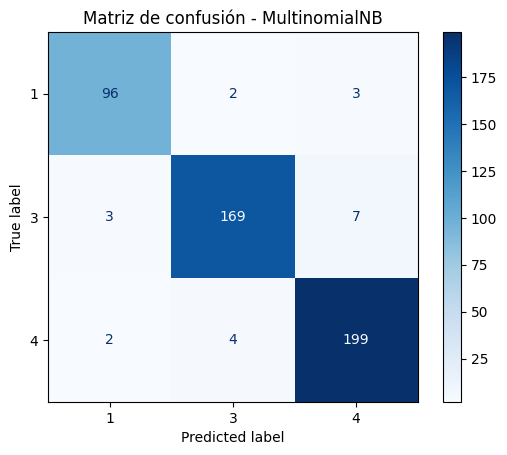

In [20]:
# Instancia con valores por defecto
mnb = MultinomialNB(alpha=0.3, fit_prior=True)

# Entrenar con la matriz TF-IDF de train
mnb.fit(Xtr, y_train)

# Predecir en test
y_pred_nb = mnb.predict(Xte)

# Métricas
print(classification_report(y_test, y_pred_nb, digits=3))
print("F1-macro:", f1_score(y_test, y_pred_nb, average='macro'))
print("Accuracy :", accuracy_score(y_test, y_pred_nb))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_nb, labels=mnb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
disp.plot(cmap="Blues", values_format="d")  # valores como enteros
plt.title("Matriz de confusión - MultinomialNB")
plt.show()